<a href="https://www.kaggle.com/code/roshanrawat/hand-digit-image-classification?scriptVersionId=110511620" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Introduction
Basic Image Classification! By the end of the project, you'd have created and trained a Neural Network model that, after the training, will be able to predict digits from hand-written images with a high degree of accuracy and along the way, you'd have developed a basic understanding of how Neural Networks work and you'd have developed a basic understanding of TensorFlow syntax with Keras as its front end.

In [2]:
import tensorflow as tf


# The Dataset
In order to understand our problem better, we will first import the data that we'd be working with and take a closer look at it. We are going to use the popular MNIST dataset which has lots of images of hand-written digits along with their labels.

In [3]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 1s 0us/step


In [4]:
print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (60000, 28, 28)
y_train shape:  (60000,)
x_test shape:  (10000, 28, 28)
y_test shape:  (10000,)


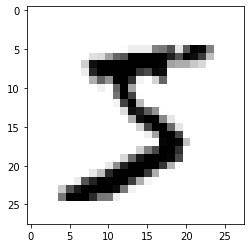

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(x_train[0], cmap = 'binary')
plt.show()

In [6]:
y_train[0]

5

In [7]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

# One Hot Encoding
We will change the way this label is represented from a class name or number to a list of all possible classes with all the classes set to 0 except the one which this example belongs to - which will be set to 1. For example:

original label	one-hot encoded label
5	            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
7	            [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
1	            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [8]:
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

**To make sure the encoding worked, let's check the shape of the encoded labels.**

In [9]:
print('y_train shape: ', y_train_encoded.shape)
print('y_test shape: ', y_test_encoded.shape)

y_train shape:  (60000, 10)
y_test shape:  (10000, 10)


**And just like before, let's also take a look at the first label and make sure that encoding is correct:**

In [10]:
y_train_encoded[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

# Neural Networks

**Preprocessing the Examples**
We will create a Neural Network which will take 784 dimensional vectors as inputs (28 rows * 28 columns) and will output a 10 dimensional vector (For the 10 classes). We have already converted the outputs to 10 dimensional, one-hot encoded vectors. Now, let's convert the input to the required format as well. We will use numpy to easily unroll the examples from (28, 28) arrays to (784, 1) vectors.

In [11]:
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))

print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)


x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)


**Each element in each example is a pixel value. Let's take a look at a few values of just one example.**

In [12]:
print(set(x_train_reshaped[0]))

{0, 1, 2, 3, 9, 11, 14, 16, 18, 23, 24, 25, 26, 27, 30, 35, 36, 39, 43, 45, 46, 49, 55, 56, 64, 66, 70, 78, 80, 81, 82, 90, 93, 94, 107, 108, 114, 119, 126, 127, 130, 132, 133, 135, 136, 139, 148, 150, 154, 156, 160, 166, 170, 171, 172, 175, 182, 183, 186, 187, 190, 195, 198, 201, 205, 207, 212, 213, 219, 221, 225, 226, 229, 238, 240, 241, 242, 244, 247, 249, 250, 251, 252, 253, 255}


Pixel values, in this dataset, range from 0 to 255. While that's fine if we want to display our images, for our neural network to learn the weights and biases for different layers, computations will be simply much more effective and fast if we normalized these values. In order to normalize the data, we can calculate the mean and standard deviation for each example.

In [13]:
x_mean = np.mean(x_train_reshaped)
x_std = np.std(x_train_reshaped)

print('mean: ', x_mean)
print('std: ', x_std)

mean:  33.318421449829934
std:  78.56748998339798


Now we will normalise both the training and test set using the mean and standard deviation we just calculated. Notice that we will need to apply the same mean and standard deviation to the test set even though we did not use the test set to calculate these values.

In [14]:
epsilon = 1e-10
x_train_norm = (x_train_reshaped - x_mean)/(x_std + epsilon)
x_test_norm = (x_test_reshaped - x_mean)/(x_std + epsilon)

Note how we added a small value to our denominator. This is because, just in case if our std was close to zero, we'd get very large values as a result. In this case, that's obviously not true but we added this anyway as a good practice since this is typically done to ensure numerical stability.

We looked at some of the values for the first training example before. Let's take a look at it again, after having normalised the values.

In [15]:
print(set(x_train_norm[0]))

{-0.38589016215482896, 1.306921966983251, 1.17964285952926, 1.803310486053816, 1.6887592893452241, 2.8215433456857437, 2.719720059722551, 1.1923707702746593, 1.7396709323268205, 2.057868700961798, 2.3633385588513764, 2.096052433197995, 1.7651267538176187, 2.7960875241949457, 2.7451758812133495, 2.45243393406917, 0.02140298169794222, -0.22042732246464067, 1.2305545025108566, 0.2759611966059242, 2.210603629906587, 2.6560805059955555, 2.6051688630139593, -0.4240738943910262, 0.4668798577869107, 0.1486820891519332, 0.3905123933145161, 1.0905474843114664, -0.09314821501064967, 1.4851127174188385, 2.7579037919587486, 1.5360243604004349, 0.07231462467953861, -0.13133194724684696, 1.294194056237852, 0.03413089244334132, 1.3451056992194483, 2.274243183633583, -0.24588314395543887, 0.772349715676489, 0.75962180493109, 0.7214380726948927, 0.1995937321335296, -0.41134598364562713, 0.5687031437501034, 0.5941589652409017, 0.9378125553666773, 0.9505404661120763, 0.6068868759863008, 0.4159682148053143

# Creating a Model
We use a Sequential class defined in Keras to create our model. All the layers are going to be Dense layers. This means, like our examples above, all the nodes of a layer would be connected to all the nodes of the preceding layer i.e. densely connected.

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(128, activation = 'relu', input_shape = (784,)),
    Dense(128, activation = 'relu'),
    Dense(10, activation = 'softmax')
])

2022-11-09 14:09:27.683583: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimasation algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

In [17]:
model.compile(
    optimizer = 'sgd',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


Notice how we have over 100 thousand parameters (the weights and biases) to learn even though we are using only 2 hidden layers. For deep neural networks, this value can be, and often is, in millions.

In order to get the approximation of our function, we just need to fit the model to our data. We will use only training set to do this learning and will reserve the test set for later when we want to check the accuracy of our model. This is because, if we used only one set for both training and testing, the results may be biased and our model may have simply memorized all the examples instead of learning the relationship between features and label

#  Training the Model
We are going to train the model for 5 epochs. Think of epoch like an iteration of all the examples going through the model. So, by setting the epochs to 3, we will go through all the training examples 3 times.

In [18]:

h = model.fit(
    x_train_norm,
    y_train_encoded,
    epochs = 3
)

2022-11-09 14:09:28.259052: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3602 - accuracy: 0.8965
Epoch 2/3
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1849 - accuracy: 0.9462
Epoch 3/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1419 - accuracy: 0.9593


In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the evaluate method on our model.

In [19]:
loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)

print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 2ms/step - loss: 0.1380 - accuracy: 0.9599
test set accuracy:  95.99000215530396


# Predictions

In [20]:
preds = model.predict(x_test_norm)

print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


We probably can't go through all the 10000 predictions for now, but we can take a look at the first few. Let's plot the first few test set images along with their predicted and actual labels and see how our trained model actually performed.

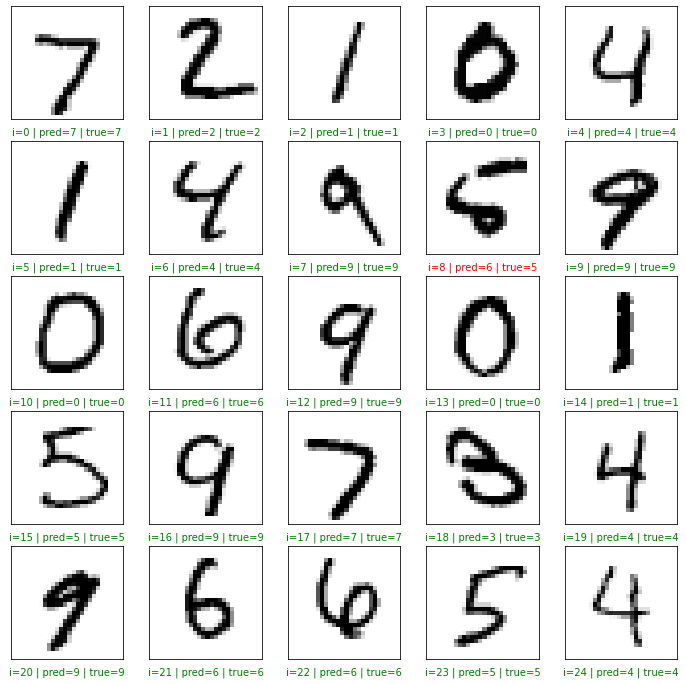

In [21]:
plt.figure(figsize = (12, 12))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

# It gets most of the predictions right!

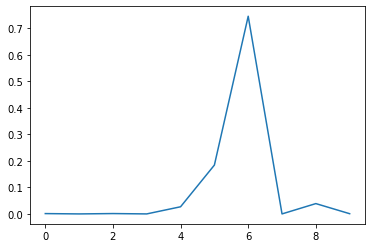

In [22]:
"""
Enter the index value in place of the value 8 below for the prediction
that you want to plot the probability scores for
"""
index = 8

plt.plot(preds[index])
plt.show()